In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split


from binaryStatistics.base_distribution import BaseDistribution
from binaryStatistics.distributions import Uniform, Thermal, PowerLaw, Sine, VelTilde, PhiAngle, Log
from binaryStatistics.plot_utils import plot_histogram

In [18]:
G = 4.3009e-03 # pc·(km/s)²·M_\odot⁻¹
def get_v2D(M, s, v_tilde):
    return np.sqrt(G*M/(s))*v_tilde

def get_vtilde(M, s, v2D):
    return v2D/np.sqrt(G*M/s)

def get_r3D(s, phi, i):
    return s / np.sqrt((np.cos(phi)**2) + (np.cos(i)**2)*(np.sin(phi)**2))

def get_semimajor_axis(r3D, ecc, phi, phi_0):
    return r3D * ( 1 + ecc*np.cos(phi - phi_0)) / (1 - ecc**2)

def get_rel_v3D(M, r3D, a):
    return np.sqrt((G*M/r3D)*(2 - r3D/a))

def get_separation(r3D, phi, i):
    return r3D * np.sqrt((np.cos(phi)**2) + (np.cos(i)**2)*(np.sin(phi)**2))

def get_psi_angle(e, phi, phi_0):
    return np.arctan(-(np.cos(phi) + e*np.cos(phi_0))/(np.sin(phi) + e*np.sin(phi_0)))

def dsq(p,*args):
    phi = p
    t, eps = args
    f = lambda x: 1/(1+eps*np.cos(x))**2
    val, err = integrate.quad(f, 0, phi)
    res = (t-val)**2 
    return res 

def get_phi_angle_Chae(e, phi_0):
    thermal = Thermal()
    f = lambda x: 1/(1+e*np.cos(x))**2
    tmax, err = integrate.quad(f, 0, 2*np.pi)  # time for one complete orbit
    t = tmax*np.random.rand()
    sol=minimize(dsq,x0=[3.],args=(t,e),bounds=[(0,2*np.pi)])  # solve the evolved azimuthal angle for t 
    phi = phi_0+ sol.x[0]  # azimuthal angle  
    return phi

def get_phi_angle(e, phi_0):
    phi = PhiAngle(
        dist_parameters={
            "e": [e],
        }
    )
    return phi.random_sample(0,2*np.pi, size=1)[0] + phi_0

In [44]:
def get_updated_dataframe(csv_file:str = "../data/667Bp_0.8.csv"):
    binary_dataframe = pd.read_csv(csv_file)
    
    thermal = Thermal()
    binary_dataframe["eccentricity"] = binary_dataframe.apply(lambda x: thermal.random_sample(0,1,size=1)[0], axis=1)

    sine = Sine()
    binary_dataframe["i_angle"] = binary_dataframe.apply(lambda x: sine.random_sample(0,np.pi/2,size=1)[0], axis=1)

    uniform = Uniform()
    binary_dataframe["phi_0"] = binary_dataframe.apply(lambda x: uniform.random_sample(0,2*np.pi,size=1)[0], axis=1)

    #binary_dataframe["phi"] = binary_dataframe.apply(lambda x: get_phi_angle_Chae(x.eccentricity, x.phi_0), axis=1)
    binary_dataframe["phi"] = binary_dataframe.apply(lambda x: get_phi_angle(x.eccentricity, x.phi_0), axis=1)

    binary_dataframe["psi"] = binary_dataframe.apply(lambda x: get_psi_angle(x.eccentricity, x.phi, x.phi_0), axis=1)

    v_tilde = VelTilde()
    binary_dataframe["v_tilde"] = binary_dataframe.apply(lambda x: v_tilde.distribution(x.phi - x.phi_0, x.phi_0, x.i_angle, x.eccentricity), axis=1)
    
    binary_dataframe["v2D"] = binary_dataframe.apply(lambda x: get_v2D(x.M,x.r,x.v_tilde), axis=1)
    #-----------
    
    binary_dataframe["r3D"] = binary_dataframe.apply(lambda x: get_r3D(x.r,x.phi,x.i_angle), axis=1)
    binary_dataframe["a"] = binary_dataframe.apply(lambda x: get_semimajor_axis(x.r3D, x.eccentricity, x.phi, x.phi_0), axis=1)
    binary_dataframe["s"] = binary_dataframe.apply(lambda x: get_separation(x.r3D, x.phi, x.i_angle), axis=1)
    
    #binary_dataframe["v3D"] = binary_dataframe.apply(lambda x: x.v2D/np.sqrt(np.cos(x.psi)**2 + (np.cos(x.i_angle)**2)*(np.sin(x.psi)**2)), axis=1)
    binary_dataframe["v3D"] = binary_dataframe.apply(lambda x: get_rel_v3D(x.M, x.r3D, x.a), axis=1)
    
    binary_dataframe["v2D_x"] = binary_dataframe.apply(lambda x: -x.v3D*np.sin(x.phi), axis=1)
    binary_dataframe["v2D_y"] = binary_dataframe.apply(lambda x: x.v3D*np.cos(x.phi)*np.cos(x.i_angle), axis=1)
    binary_dataframe["v2D_comp"] = binary_dataframe.apply(lambda x: np.sqrt(x.v2D_x**2 + x.v2D_y**2), axis=1)
    binary_dataframe["v_tilde_comp"] = binary_dataframe.apply(lambda x: get_vtilde(x.M, x.s, x.v2D_comp), axis=1)
    
    return binary_dataframe

## 3D velocity de-projection

1. Compute the $v_{2D}$ projected velocity using the formula:
$$
v_{2D} = \sqrt{\frac{GM}{s}} \tilde{v}(\phi, \phi_0, i, e),
$$
where $M$ is the binary's total mass, $s$ is the 2D projected separation of the binary and $\tilde{v}(\phi, \phi_0, i, e)$ is the adimensional velocity computed from the distributions of the angles $\phi$, $\phi_0$ and $i$, as well as the orbit's ellipticity.

2. Compute the de-projected 3D separation using the formulation (Chae, 2023; equation 8):
$$
r_{3D} = \frac{s}{\sqrt{\cos^2 \phi + \cos^2 i \sin^2 \phi}}.
$$

3. Compute the auxiliar angle variable (Chae, 2023; equation 7):
$$
\psi = \tan^{-1} \left( - \frac{\cos \phi + e \cos \phi_0}{\sin \phi + e \sin \phi_0} \right),
$$

4. Compute the de-projected 3D velocity using the formula (Chae, 2023; equation 9):
$$
v_{3D} = \frac{v_{2D}}{\sqrt{\cos^2 \psi + \cos^2 i \sin^2 \psi}}.
$$

5. Use the de-projected 3D velocity to construct the $x$ and $y$ velocity projected components (Chae, 2023; equation 18):
$$
v_{2D_x} = - v_{3D} \sin \phi,
$$
$$
v_{2D_y} = v_{3D} \cos \phi \cos i.
$$

6. Finally, reconstruct the 2D projected velocity:
$$
v^*_{2D} = \sqrt{v_{2D_x}^2 + v_{2D_y}^2}
$$


In [53]:
binary_dataframe = pd.concat([get_updated_dataframe(csv_file="../data/667Bp_0.8.csv") for _ in range(2)])

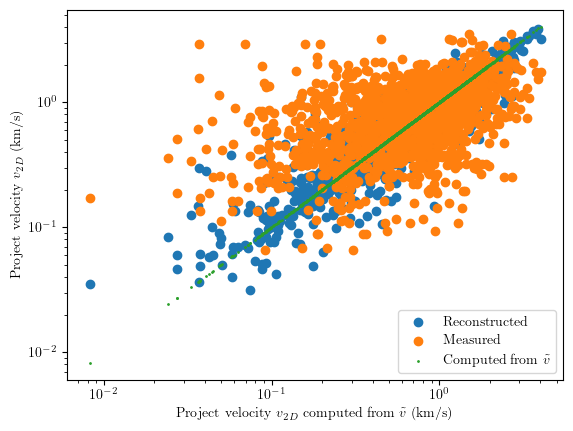

In [54]:
plt.scatter(binary_dataframe["v2D"], binary_dataframe["v2D_comp"], label="Reconstructed")
plt.scatter(binary_dataframe["v2D"], binary_dataframe["V2D"], label="Measured")
plt.scatter(binary_dataframe["v2D"], binary_dataframe["v2D"], alpha=1, s=1, label="Computed from $\\tilde{v}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Project velocity $v_{2D}$ computed from $\\tilde{v}$ (km/s)")
plt.ylabel("Project velocity $v_{2D}$ (km/s)")
plt.legend()

(array([ 4.,  3.,  3.,  4.,  6., 12., 10.,  8., 17., 33., 38., 56., 45.,
        59., 58., 65., 60., 56., 45., 55., 63., 73., 70., 67., 55., 68.,
        59., 50., 57., 43., 33., 20., 11.,  6.,  9.,  7.,  2.,  1.,  2.,
         1.]),
 array([ 0.6112187 ,  0.89641603,  1.18161337,  1.4668107 ,  1.75200803,
         2.03720536,  2.32240269,  2.60760002,  2.89279735,  3.17799468,
         3.46319202,  3.74838935,  4.03358668,  4.31878401,  4.60398134,
         4.88917867,  5.174376  ,  5.45957333,  5.74477067,  6.029968  ,
         6.31516533,  6.60036266,  6.88555999,  7.17075732,  7.45595465,
         7.74115198,  8.02634932,  8.31154665,  8.59674398,  8.88194131,
         9.16713864,  9.45233597,  9.7375333 , 10.02273063, 10.30792797,
        10.5931253 , 10.87832263, 11.16351996, 11.44871729, 11.73391462,
        12.01911195]),
 <BarContainer object of 40 artists>)

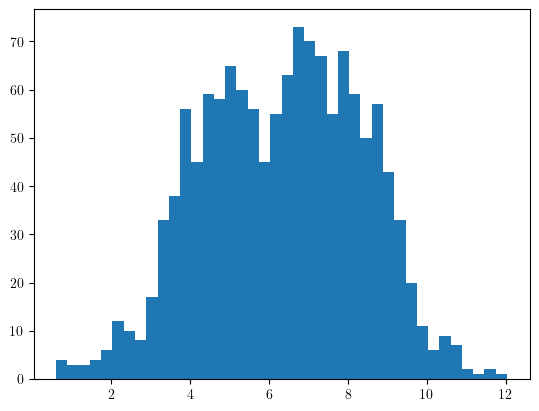

In [55]:
plt.hist(binary_dataframe["phi"], bins=40)

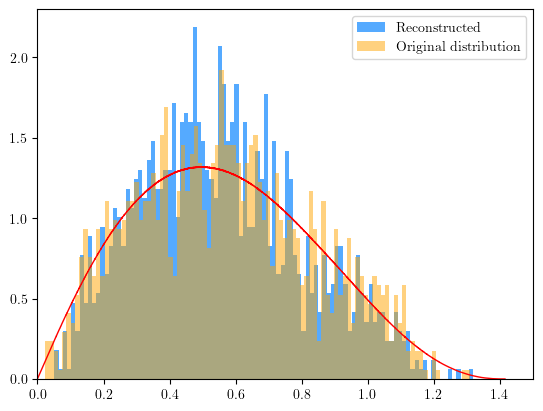

In [56]:
## Extract data with the high resolution \tilde{v} distribution
with open("../data/VTil.dat","r") as file:
    lines = file.readlines()
    
    v = []
    v_dist = []
    for line in lines:
        vel, dist = line.strip().split(" ")
        v.append(float(vel))
        v_dist.append(float(dist))
_=plt.hist(binary_dataframe["v_tilde_comp"], bins=100, density=True, alpha=1.0, color="#55AAFF", label="Reconstructed")
_=plt.hist(binary_dataframe["v_tilde"], bins=100, density=True, alpha=0.5, color="orange", label="Original distribution")
plt.plot(v, v_dist, linewidth=1, color="red")         
plt.xlim(0, 1.5)
plt.legend()

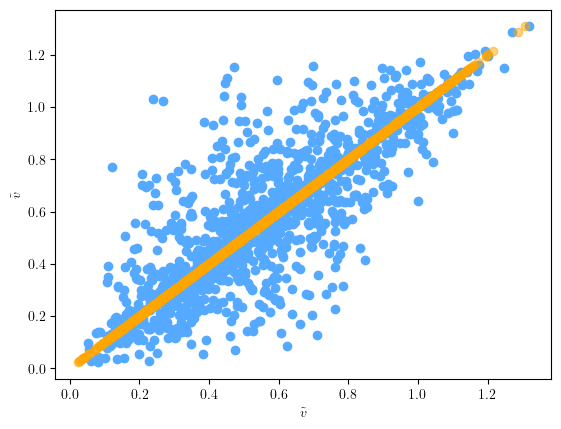

In [57]:
for value, v_comp, v in zip(binary_dataframe["v_tilde"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"$\tilde{v}$")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["v_tilde"], color="orange", alpha=0.5)

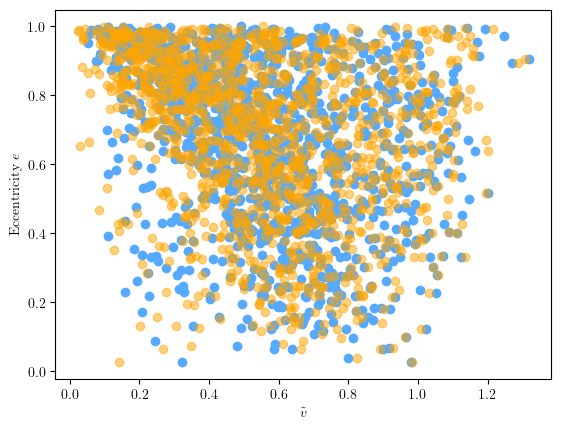

In [58]:
for value, v_comp, v in zip(binary_dataframe["eccentricity"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"Eccentricity ${e}$")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["eccentricity"], color="orange", alpha=0.5)

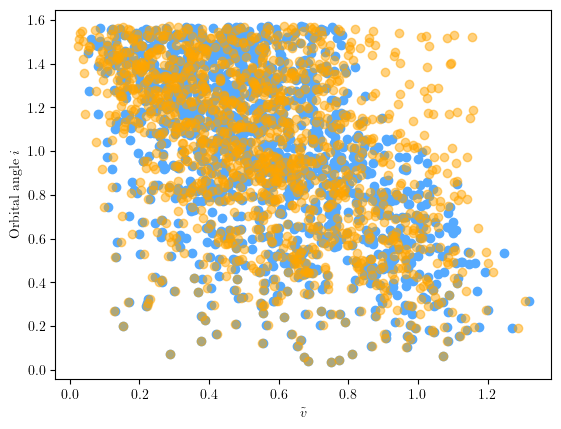

In [59]:
for value, v_comp, v in zip(binary_dataframe["i_angle"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"Orbital angle ${i}$")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["i_angle"], color="orange", alpha=0.5)

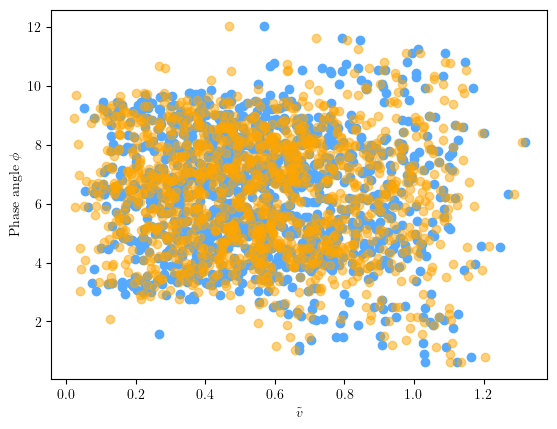

In [60]:
for value, v_comp, v in zip(binary_dataframe["phi"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"Phase angle $\phi$")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["phi"], color="orange", alpha=0.5)

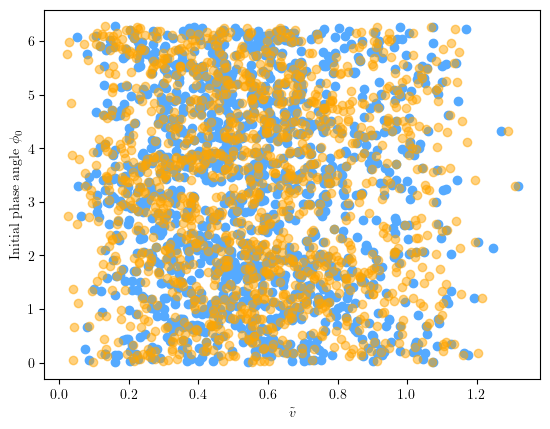

In [61]:
for value, v_comp, v in zip(binary_dataframe["phi_0"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"Initial phase angle $\phi_0$")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["phi_0"], color="orange", alpha=0.5)

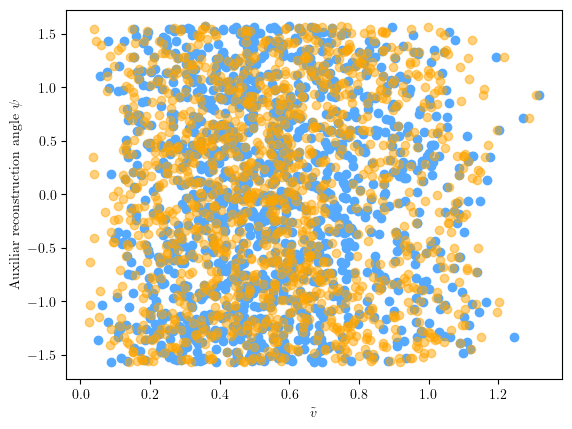

In [62]:
for value, v_comp, v in zip(binary_dataframe["psi"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"Auxiliar reconstruction angle $\psi$")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["psi"], color="orange", alpha=0.5)

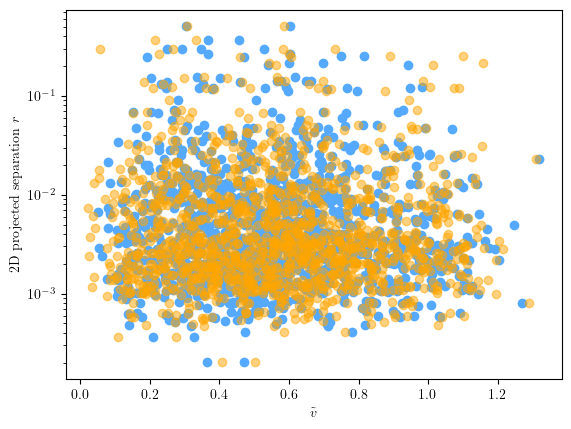

In [63]:
for value, v_comp, v in zip(binary_dataframe["r"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"2D projected separation $r$")
    plt.yscale("log")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["r"], color="orange", alpha=0.5)

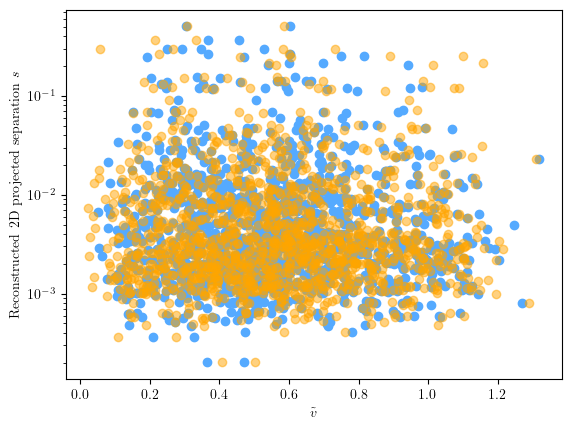

In [64]:
for value, v_comp, v in zip(binary_dataframe["s"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"Reconstructed 2D projected separation $s$")
    plt.yscale("log")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["s"], color="orange", alpha=0.5)

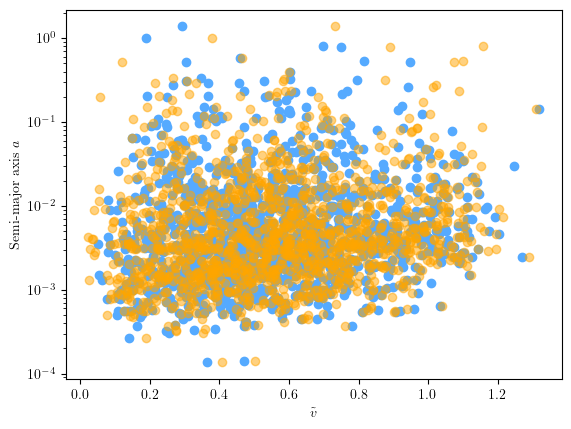

In [65]:
for value, v_comp, v in zip(binary_dataframe["a"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"Semi-major axis $a$")
    plt.yscale("log")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["a"], color="orange", alpha=0.5)

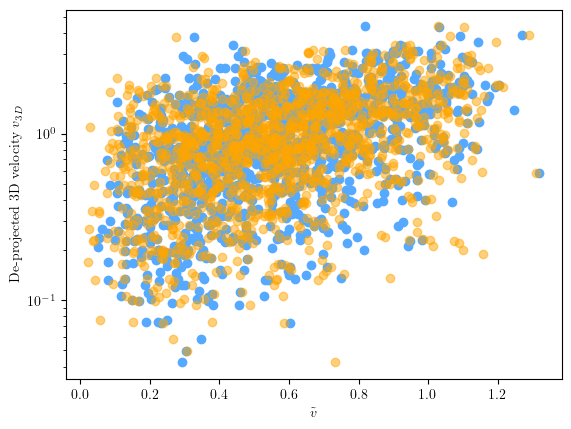

In [66]:
for value, v_comp, v in zip(binary_dataframe["v3D"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"De-projected 3D velocity $v_{3D}$")
    plt.yscale("log")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["v3D"], color="orange", alpha=0.5)

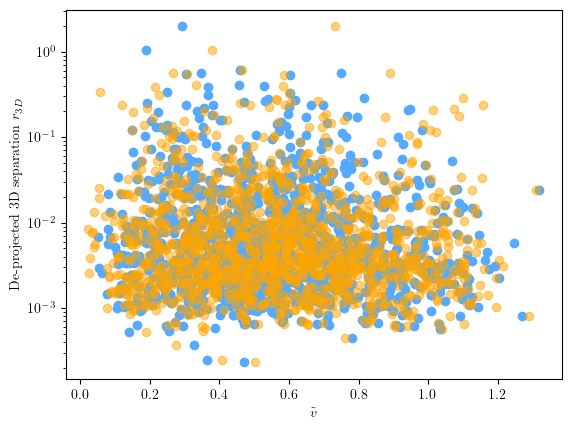

In [67]:
for value, v_comp, v in zip(binary_dataframe["r3D"], binary_dataframe["v_tilde_comp"], binary_dataframe["v_tilde"]):
    if v_comp <= np.sqrt(2):
        color = "#55AAFF"
    else:
        color = "red"
    plt.scatter(v_comp, value, color=color)
    plt.xlabel(r"$\tilde{v}$")
    plt.ylabel(r"De-projected 3D separation $r_{3D}$")
    plt.yscale("log")
plt.scatter(binary_dataframe["v_tilde"], binary_dataframe["r3D"], color="orange", alpha=0.5)